In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

## Loading Data

In [16]:
# define column names
colnames = ["unit_number", "time_in_cycles", "setting_1", "setting_2", "setting_3"]
extra_cols = ["measurement_"+str(i) for i in range(1,26)]
colnames = colnames + extra_cols

In [17]:
# load training data
df_train_FD001 = pd.read_csv("data/CMAPSSData/train_FD001.txt", delimiter=" ", names=colnames, header=None)
# load test data
df_test_FD001 = pd.read_csv("data/CMAPSSData/test_FD001.txt", delimiter=" ", names=colnames, header=None)
# load ground truth
df_rul = pd.read_csv("data/CMAPSSData/RUL_FD001.txt", names = ["remaining_cycles"], header=None)

In [18]:
# look at few training data
df_train_FD001.head()

unit_number  time_in_cycles  setting_1  setting_2  setting_3  \
0            1               1    -0.0007    -0.0004      100.0   
1            1               2     0.0019    -0.0003      100.0   
2            1               3    -0.0043     0.0003      100.0   
3            1               4     0.0007     0.0000      100.0   
4            1               5    -0.0019    -0.0002      100.0   

   measurement_1  measurement_2  measurement_3  measurement_4  measurement_5  \
0         518.67         641.82        1589.70        1400.60          14.62   
1         518.67         642.15        1591.82        1403.14          14.62   
2         518.67         642.35        1587.99        1404.20          14.62   
3         518.67         642.35        1582.79        1401.87          14.62   
4         518.67         642.37        1582.85        1406.22          14.62   

   ...  measurement_16  measurement_17  measurement_18  measurement_19  \
0  ...            0.03             392            2388           100.0   
1  ...            0.03             392            2388           100.0   
2  ...            0.03             390            2388           100.0   
3  ...            0.03             392            2388           100.0   
4  ...            0.03             393            2388           100.0   

   measurement_20  measurement_21  measurement_22  measurement_23  \
0           39.06         23.4190             NaN             NaN   
1           39.00         23.4236             NaN             NaN   
2           38.95         23.3442             NaN             NaN   
3           38.88         23.3739             NaN             NaN   
4           38.90         23.4044             NaN             NaN   

   measurement_24  measurement_25  
0             NaN             NaN  
1             NaN             NaN  
2             NaN             NaN  
3             NaN             NaN  
4             NaN             NaN  

[5 rows x 30 columns]

In [19]:
# look at few test data
df_test_FD001.head()

unit_number  time_in_cycles  setting_1  setting_2  setting_3  \
0            1               1     0.0023     0.0003      100.0   
1            1               2    -0.0027    -0.0003      100.0   
2            1               3     0.0003     0.0001      100.0   
3            1               4     0.0042     0.0000      100.0   
4            1               5     0.0014     0.0000      100.0   

   measurement_1  measurement_2  measurement_3  measurement_4  measurement_5  \
0         518.67         643.02        1585.29        1398.21          14.62   
1         518.67         641.71        1588.45        1395.42          14.62   
2         518.67         642.46        1586.94        1401.34          14.62   
3         518.67         642.44        1584.12        1406.42          14.62   
4         518.67         642.51        1587.19        1401.92          14.62   

   ...  measurement_16  measurement_17  measurement_18  measurement_19  \
0  ...            0.03             392            2388           100.0   
1  ...            0.03             393            2388           100.0   
2  ...            0.03             393            2388           100.0   
3  ...            0.03             391            2388           100.0   
4  ...            0.03             390            2388           100.0   

   measurement_20  measurement_21  measurement_22  measurement_23  \
0           38.86         23.3735             NaN             NaN   
1           39.02         23.3916             NaN             NaN   
2           39.08         23.4166             NaN             NaN   
3           39.00         23.3737             NaN             NaN   
4           38.99         23.4130             NaN             NaN   

   measurement_24  measurement_25  
0             NaN             NaN  
1             NaN             NaN  
2             NaN             NaN  
3             NaN             NaN  
4             NaN             NaN  

[5 rows x 30 columns]

In [20]:
# look at the ground truth for the test set
print(df_rul)

    remaining_cycles
0                112
1                 98
2                 69
3                 82
4                 91
..               ...
95               137
96                82
97                59
98               117
99                20

[100 rows x 1 columns]


## Exploratory Data Analysis - EDA & Pre-processing & Feature Engineering

### Basic data quality checks

In [21]:
# check that the number of units in the test data matches the provided number of ground truth data
print(df_test_FD001["unit_number"].nunique())

100


In [22]:
# check data types, null/missing values, etc...
df_train_FD001.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   unit_number     20631 non-null  int64  
 1   time_in_cycles  20631 non-null  int64  
 2   setting_1       20631 non-null  float64
 3   setting_2       20631 non-null  float64
 4   setting_3       20631 non-null  float64
 5   measurement_1   20631 non-null  float64
 6   measurement_2   20631 non-null  float64
 7   measurement_3   20631 non-null  float64
 8   measurement_4   20631 non-null  float64
 9   measurement_5   20631 non-null  float64
 10  measurement_6   20631 non-null  float64
 11  measurement_7   20631 non-null  float64
 12  measurement_8   20631 non-null  float64
 13  measurement_9   20631 non-null  float64
 14  measurement_10  20631 non-null  float64
 15  measurement_11  20631 non-null  float64
 16  measurement_12  20631 non-null  float64
 17  measurement_13  20631 non-null 

In [23]:
# print basic stats for the training data
df_train_FD001.describe()

unit_number  time_in_cycles     setting_1     setting_2  setting_3  \
count  20631.000000    20631.000000  20631.000000  20631.000000    20631.0   
mean      51.506568      108.807862     -0.000009      0.000002      100.0   
std       29.227633       68.880990      0.002187      0.000293        0.0   
min        1.000000        1.000000     -0.008700     -0.000600      100.0   
25%       26.000000       52.000000     -0.001500     -0.000200      100.0   
50%       52.000000      104.000000      0.000000      0.000000      100.0   
75%       77.000000      156.000000      0.001500      0.000300      100.0   
max      100.000000      362.000000      0.008700      0.000600      100.0   

       measurement_1  measurement_2  measurement_3  measurement_4  \
count       20631.00   20631.000000   20631.000000   20631.000000   
mean          518.67     642.680934    1590.523119    1408.933782   
std             0.00       0.500053       6.131150       9.000605   
min           518.67     641.210000    1571.040000    1382.250000   
25%           518.67     642.325000    1586.260000    1402.360000   
50%           518.67     642.640000    1590.100000    1408.040000   
75%           518.67     643.000000    1594.380000    1414.555000   
max           518.67     644.530000    1616.910000    1441.490000   

       measurement_5  ...  measurement_16  measurement_17  measurement_18  \
count   2.063100e+04  ...    2.063100e+04    20631.000000         20631.0   
mean    1.462000e+01  ...    3.000000e-02      393.210654          2388.0   
std     1.776400e-15  ...    1.387812e-17        1.548763             0.0   
min     1.462000e+01  ...    3.000000e-02      388.000000          2388.0   
25%     1.462000e+01  ...    3.000000e-02      392.000000          2388.0   
50%     1.462000e+01  ...    3.000000e-02      393.000000          2388.0   
75%     1.462000e+01  ...    3.000000e-02      394.000000          2388.0   
max     1.462000e+01  ...    3.000000e-02      400.000000          2388.0   

       measurement_19  measurement_20  measurement_21  measurement_22  \
count         20631.0    20631.000000    20631.000000             0.0   
mean            100.0       38.816271       23.289705             NaN   
std               0.0        0.180746        0.108251             NaN   
min             100.0       38.140000       22.894200             NaN   
25%             100.0       38.700000       23.221800             NaN   
50%             100.0       38.830000       23.297900             NaN   
75%             100.0       38.950000       23.366800             NaN   
max             100.0       39.430000       23.618400             NaN   

       measurement_23  measurement_24  measurement_25  
count             0.0             0.0             0.0  
mean              NaN             NaN             NaN  
std               NaN             NaN             NaN  
min               NaN             NaN             NaN  
25%               NaN             NaN             NaN  
50%               NaN             NaN             NaN  
75%               NaN             NaN             NaN  
max               NaN             NaN             NaN  

[8 rows x 30 columns]

In [24]:
# print some stats for the test data
df_test_FD001.describe()

unit_number  time_in_cycles     setting_1     setting_2  setting_3  \
count  13096.000000    13096.000000  13096.000000  13096.000000    13096.0   
mean      51.543907       76.836515     -0.000011      0.000004      100.0   
std       28.289423       53.057749      0.002203      0.000294        0.0   
min        1.000000        1.000000     -0.008200     -0.000600      100.0   
25%       28.000000       33.000000     -0.001500     -0.000200      100.0   
50%       52.000000       69.000000     -0.000000     -0.000000      100.0   
75%       76.000000      113.000000      0.001500      0.000300      100.0   
max      100.000000      303.000000      0.007800      0.000700      100.0   

       measurement_1  measurement_2  measurement_3  measurement_4  \
count       13096.00   13096.000000   13096.000000   13096.000000   
mean          518.67     642.475088    1588.099204    1404.735362   
std             0.00       0.400899       5.003274       6.688309   
min           518.67     641.130000    1569.040000    1384.390000   
25%           518.67     642.197500    1584.600000    1399.950000   
50%           518.67     642.460000    1587.990000    1404.440000   
75%           518.67     642.740000    1591.362500    1409.050000   
max           518.67     644.300000    1607.550000    1433.360000   

       measurement_5  ...  measurement_16  measurement_17  measurement_18  \
count   1.309600e+04  ...    1.309600e+04    13096.000000         13096.0   
mean    1.462000e+01  ...    3.000000e-02      392.571625          2388.0   
std     1.776425e-15  ...    1.040874e-17        1.233577             0.0   
min     1.462000e+01  ...    3.000000e-02      389.000000          2388.0   
25%     1.462000e+01  ...    3.000000e-02      392.000000          2388.0   
50%     1.462000e+01  ...    3.000000e-02      393.000000          2388.0   
75%     1.462000e+01  ...    3.000000e-02      393.000000          2388.0   
max     1.462000e+01  ...    3.000000e-02      397.000000          2388.0   

       measurement_19  measurement_20  measurement_21  measurement_22  \
count         13096.0    13096.000000    13096.000000             0.0   
mean            100.0       38.892502       23.335743             NaN   
std               0.0        0.141681        0.084120             NaN   
min             100.0       38.310000       22.935400             NaN   
25%             100.0       38.800000       23.281600             NaN   
50%             100.0       38.900000       23.339200             NaN   
75%             100.0       38.990000       23.393600             NaN   
max             100.0       39.410000       23.641900             NaN   

       measurement_23  measurement_24  measurement_25  
count             0.0             0.0             0.0  
mean              NaN             NaN             NaN  
std               NaN             NaN             NaN  
min               NaN             NaN             NaN  
25%               NaN             NaN             NaN  
50%               NaN             NaN             NaN  
75%               NaN             NaN             NaN  
max               NaN             NaN             NaN  

[8 rows x 30 columns]

### Pre-processing - part 1

In [25]:
# remove some measurements without any extra information (e.g. setting 3, and measurement 1, 18, 19 are always the same value 
# and measurements 22-25 are always missing both in train and test)
df_train_FD001 = df_train_FD001.loc[:, ~df_train_FD001.columns.isin(['setting_3','measurement_1', 'measurement_18', 'measurement_19', 'measurement_22', 'measurement_23', 'measurement_24', 'measurement_25'])]
df_test_FD001 = df_test_FD001.loc[:, ~df_test_FD001.columns.isin(['setting_3','measurement_1', 'measurement_18', 'measurement_19', 'measurement_22', 'measurement_23', 'measurement_24', 'measurement_25'])]

In [26]:
df_train_FD001.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1    -0.0007    -0.0004         641.82   
1            1               2     0.0019    -0.0003         642.15   
2            1               3    -0.0043     0.0003         642.35   
3            1               4     0.0007     0.0000         642.35   
4            1               5    -0.0019    -0.0002         642.37   

   measurement_3  measurement_4  measurement_5  measurement_6  measurement_7  \
0        1589.70        1400.60          14.62          21.61         554.36   
1        1591.82        1403.14          14.62          21.61         553.75   
2        1587.99        1404.20          14.62          21.61         554.26   
3        1582.79        1401.87          14.62          21.61         554.45   
4        1582.85        1406.22          14.62          21.61         554.00   

   ...  measurement_10  measurement_11  measurement_12  measurement_13  \
0  ...             1.3           47.47          521.66         2388.02   
1  ...             1.3           47.49          522.28         2388.07   
2  ...             1.3           47.27          522.42         2388.03   
3  ...             1.3           47.13          522.86         2388.08   
4  ...             1.3           47.28          522.19         2388.04   

   measurement_14  measurement_15  measurement_16  measurement_17  \
0         8138.62          8.4195            0.03             392   
1         8131.49          8.4318            0.03             392   
2         8133.23          8.4178            0.03             390   
3         8133.83          8.3682            0.03             392   
4         8133.80          8.4294            0.03             393   

   measurement_20  measurement_21  
0           39.06         23.4190  
1           39.00         23.4236  
2           38.95         23.3442  
3           38.88         23.3739  
4           38.90         23.4044  

[5 rows x 22 columns]

In [27]:
df_test_FD001.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1     0.0023     0.0003         643.02   
1            1               2    -0.0027    -0.0003         641.71   
2            1               3     0.0003     0.0001         642.46   
3            1               4     0.0042     0.0000         642.44   
4            1               5     0.0014     0.0000         642.51   

   measurement_3  measurement_4  measurement_5  measurement_6  measurement_7  \
0        1585.29        1398.21          14.62          21.61         553.90   
1        1588.45        1395.42          14.62          21.61         554.85   
2        1586.94        1401.34          14.62          21.61         554.11   
3        1584.12        1406.42          14.62          21.61         554.07   
4        1587.19        1401.92          14.62          21.61         554.16   

   ...  measurement_10  measurement_11  measurement_12  measurement_13  \
0  ...             1.3           47.20          521.72         2388.03   
1  ...             1.3           47.50          522.16         2388.06   
2  ...             1.3           47.50          521.97         2388.03   
3  ...             1.3           47.28          521.38         2388.05   
4  ...             1.3           47.31          522.15         2388.03   

   measurement_14  measurement_15  measurement_16  measurement_17  \
0         8125.55          8.4052            0.03             392   
1         8139.62          8.3803            0.03             393   
2         8130.10          8.4441            0.03             393   
3         8132.90          8.3917            0.03             391   
4         8129.54          8.4031            0.03             390   

   measurement_20  measurement_21  
0           38.86         23.3735  
1           39.02         23.3916  
2           39.08         23.4166  
3           39.00         23.3737  
4           38.99         23.4130  

[5 rows x 22 columns]

### Visualization - measurements

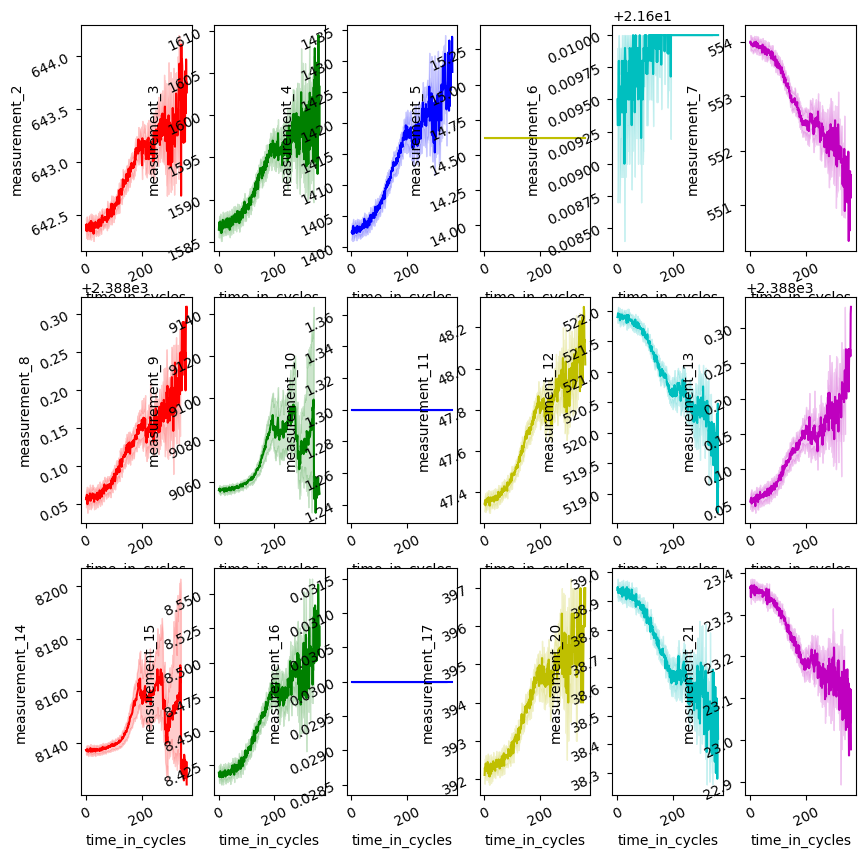

In [28]:
# create plots of the measurements to see to identify patterns
fig, ax = plt.subplots(3, 6, figsize = (10,10))
sns.lineplot(x = "time_in_cycles", y = "measurement_2", color = 'r', data = df_train_FD001, ax = ax[0][0])
ax[0][0].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_3", color = 'g', data = df_train_FD001, ax = ax[0][1])
ax[0][1].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_4", color = 'b', data = df_train_FD001, ax = ax[0][2])
ax[0][2].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_5", color = 'y', data = df_train_FD001, ax = ax[0][3])
ax[0][3].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_6", color = 'c', data = df_train_FD001, ax = ax[0][4])
ax[0][4].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_7", color = 'm', data = df_train_FD001, ax = ax[0][5])
ax[0][5].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_8", color = 'r', data = df_train_FD001, ax = ax[1][0])
ax[1][0].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_9", color = 'g', data = df_train_FD001, ax = ax[1][1])
ax[1][1].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_10", color = 'b', data = df_train_FD001, ax = ax[1][2])
ax[1][2].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_11", color = 'y', data = df_train_FD001, ax = ax[1][3])
ax[1][3].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_12", color = 'c', data = df_train_FD001, ax = ax[1][4])
ax[1][4].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_13", color = 'm', data = df_train_FD001, ax = ax[1][5])
ax[1][5].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_14", color = 'r', data = df_train_FD001, ax = ax[2][0])
ax[2][0].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_15", color = 'g', data = df_train_FD001, ax = ax[2][1])
ax[2][1].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_16", color = 'b', data = df_train_FD001, ax = ax[2][2])
ax[2][2].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_17", color = 'y', data = df_train_FD001, ax = ax[2][3])
ax[2][3].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_20", color = 'c', data = df_train_FD001, ax = ax[2][4])
ax[2][4].tick_params(labelrotation = 25)

sns.lineplot(x = "time_in_cycles", y = "measurement_21", color = 'm', data = df_train_FD001, ax = ax[2][5])
ax[2][5].tick_params(labelrotation = 25)

### Pre-processing - part 2

In [29]:
# remove measurements 5, 10 and 16 since from the visualizations, it can be seen there would have little to no effect on the prediction
df_train_FD001 = df_train_FD001.loc[:, ~df_train_FD001.columns.isin(['measurement_5', 'measurement_10', 'measurement_16'])]
df_test_FD001 = df_test_FD001.loc[:, ~df_test_FD001.columns.isin(['measurement_5', 'measurement_10', 'measurement_16'])]

In [30]:
df_train_FD001.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1    -0.0007    -0.0004         641.82   
1            1               2     0.0019    -0.0003         642.15   
2            1               3    -0.0043     0.0003         642.35   
3            1               4     0.0007     0.0000         642.35   
4            1               5    -0.0019    -0.0002         642.37   

   measurement_3  measurement_4  measurement_6  measurement_7  measurement_8  \
0        1589.70        1400.60          21.61         554.36        2388.06   
1        1591.82        1403.14          21.61         553.75        2388.04   
2        1587.99        1404.20          21.61         554.26        2388.08   
3        1582.79        1401.87          21.61         554.45        2388.11   
4        1582.85        1406.22          21.61         554.00        2388.06   

   measurement_9  measurement_11  measurement_12  measurement_13  \
0        9046.19           47.47          521.66         2388.02   
1        9044.07           47.49          522.28         2388.07   
2        9052.94           47.27          522.42         2388.03   
3        9049.48           47.13          522.86         2388.08   
4        9055.15           47.28          522.19         2388.04   

   measurement_14  measurement_15  measurement_17  measurement_20  \
0         8138.62          8.4195             392           39.06   
1         8131.49          8.4318             392           39.00   
2         8133.23          8.4178             390           38.95   
3         8133.83          8.3682             392           38.88   
4         8133.80          8.4294             393           38.90   

   measurement_21  
0         23.4190  
1         23.4236  
2         23.3442  
3         23.3739  
4         23.4044

In [31]:
df_test_FD001.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1     0.0023     0.0003         643.02   
1            1               2    -0.0027    -0.0003         641.71   
2            1               3     0.0003     0.0001         642.46   
3            1               4     0.0042     0.0000         642.44   
4            1               5     0.0014     0.0000         642.51   

   measurement_3  measurement_4  measurement_6  measurement_7  measurement_8  \
0        1585.29        1398.21          21.61         553.90        2388.04   
1        1588.45        1395.42          21.61         554.85        2388.01   
2        1586.94        1401.34          21.61         554.11        2388.05   
3        1584.12        1406.42          21.61         554.07        2388.03   
4        1587.19        1401.92          21.61         554.16        2388.01   

   measurement_9  measurement_11  measurement_12  measurement_13  \
0        9050.17           47.20          521.72         2388.03   
1        9054.42           47.50          522.16         2388.06   
2        9056.96           47.50          521.97         2388.03   
3        9045.29           47.28          521.38         2388.05   
4        9044.55           47.31          522.15         2388.03   

   measurement_14  measurement_15  measurement_17  measurement_20  \
0         8125.55          8.4052             392           38.86   
1         8139.62          8.3803             393           39.02   
2         8130.10          8.4441             393           39.08   
3         8132.90          8.3917             391           39.00   
4         8129.54          8.4031             390           38.99   

   measurement_21  
0         23.3735  
1         23.3916  
2         23.4166  
3         23.3737  
4         23.4130

### Feature engineering - part 1

In [32]:
# since for the test data we have a RUL value, let's estimate it also for the training data (approx: max cycles for a certain unit - current max cycle)
# first, we keep  the maximum cycles per unit as column for both and training and test data
df_ = (df_train_FD001.groupby("unit_number", group_keys=False).apply(lambda x: x.assign(max_cycles=x["time_in_cycles"].max())))
df_test = (df_test_FD001.groupby("unit_number", group_keys=False).apply(lambda x: x.assign(max_cycles=x["time_in_cycles"].max())))

/var/folders/wy/fn4vzkqd1c7gtprtw67bjwdh0000gn/T/ipykernel_2031/3567075682.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/wy/fn4vzkqd1c7gtprtw67bjwdh0000gn/T/ipykernel_2031/3567075682.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [33]:
# generate the new column RUL only for the training data
df = (df_.groupby("unit_number", group_keys=False).apply(lambda x: x.assign(RUL=x["time_in_cycles"].max() - x["time_in_cycles"])))

/var/folders/wy/fn4vzkqd1c7gtprtw67bjwdh0000gn/T/ipykernel_2031/1220230844.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [34]:
df.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1    -0.0007    -0.0004         641.82   
1            1               2     0.0019    -0.0003         642.15   
2            1               3    -0.0043     0.0003         642.35   
3            1               4     0.0007     0.0000         642.35   
4            1               5    -0.0019    -0.0002         642.37   

   measurement_3  measurement_4  measurement_6  measurement_7  measurement_8  \
0        1589.70        1400.60          21.61         554.36        2388.06   
1        1591.82        1403.14          21.61         553.75        2388.04   
2        1587.99        1404.20          21.61         554.26        2388.08   
3        1582.79        1401.87          21.61         554.45        2388.11   
4        1582.85        1406.22          21.61         554.00        2388.06   

   ...  measurement_11  measurement_12  measurement_13  measurement_14  \
0  ...           47.47          521.66         2388.02         8138.62   
1  ...           47.49          522.28         2388.07         8131.49   
2  ...           47.27          522.42         2388.03         8133.23   
3  ...           47.13          522.86         2388.08         8133.83   
4  ...           47.28          522.19         2388.04         8133.80   

   measurement_15  measurement_17  measurement_20  measurement_21  max_cycles  \
0          8.4195             392           39.06         23.4190         192   
1          8.4318             392           39.00         23.4236         192   
2          8.4178             390           38.95         23.3442         192   
3          8.3682             392           38.88         23.3739         192   
4          8.4294             393           38.90         23.4044         192   

   RUL  
0  191  
1  190  
2  189  
3  188  
4  187  

[5 rows x 21 columns]

In [35]:
df_test.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1     0.0023     0.0003         643.02   
1            1               2    -0.0027    -0.0003         641.71   
2            1               3     0.0003     0.0001         642.46   
3            1               4     0.0042     0.0000         642.44   
4            1               5     0.0014     0.0000         642.51   

   measurement_3  measurement_4  measurement_6  measurement_7  measurement_8  \
0        1585.29        1398.21          21.61         553.90        2388.04   
1        1588.45        1395.42          21.61         554.85        2388.01   
2        1586.94        1401.34          21.61         554.11        2388.05   
3        1584.12        1406.42          21.61         554.07        2388.03   
4        1587.19        1401.92          21.61         554.16        2388.01   

   measurement_9  measurement_11  measurement_12  measurement_13  \
0        9050.17           47.20          521.72         2388.03   
1        9054.42           47.50          522.16         2388.06   
2        9056.96           47.50          521.97         2388.03   
3        9045.29           47.28          521.38         2388.05   
4        9044.55           47.31          522.15         2388.03   

   measurement_14  measurement_15  measurement_17  measurement_20  \
0         8125.55          8.4052             392           38.86   
1         8139.62          8.3803             393           39.02   
2         8130.10          8.4441             393           39.08   
3         8132.90          8.3917             391           39.00   
4         8129.54          8.4031             390           38.99   

   measurement_21  max_cycles  
0         23.3735          31  
1         23.3916          31  
2         23.4166          31  
3         23.3737          31  
4         23.4130          31

### Visualization - correlation

<Axes: >

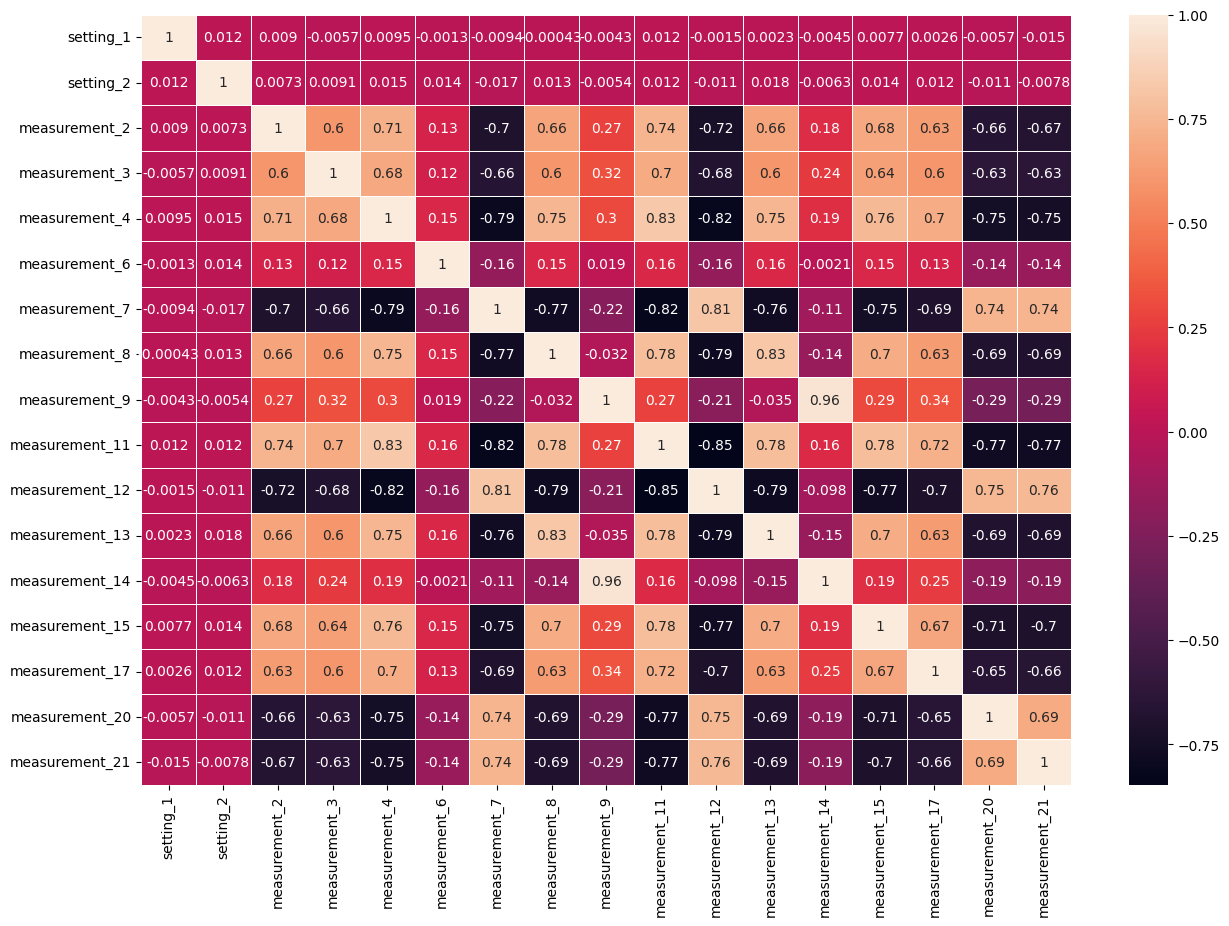

In [36]:
# let's look at the correlation between the various features
features = [c for c in df.columns if c not in ["unit_number", "time_in_cycles", "max_cycles", "RUL"]]
plt.subplots(figsize=(15, 10))
sns.heatmap(df[features].corr(), annot=True, cbar=True, linewidths=0.5)

### Feature engineering - PCA

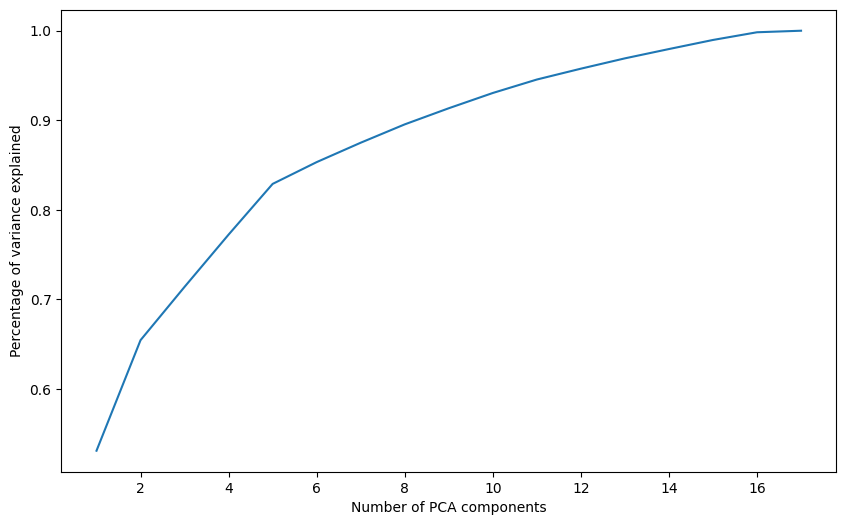

In [37]:
# do a PCA and plot the variance explained by the components
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA())
])
pipeline.fit(df[features])
csum_variance = pipeline.named_steps["pca"].explained_variance_ratio_.cumsum()
plt.subplots(figsize=(10, 6))
plt.plot(np.arange(1, csum_variance.shape[0]+1), csum_variance)
plt.xlabel("Number of PCA components")
plt.ylabel("Percentage of variance explained")
plt.show()

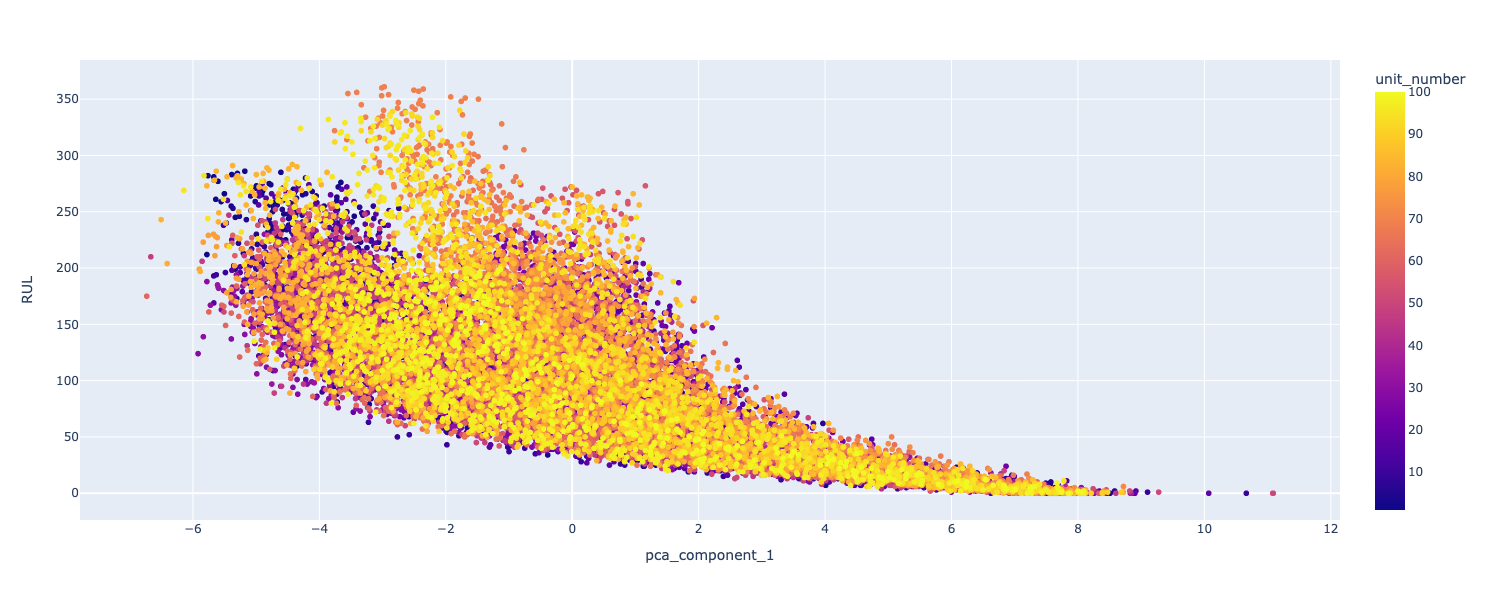

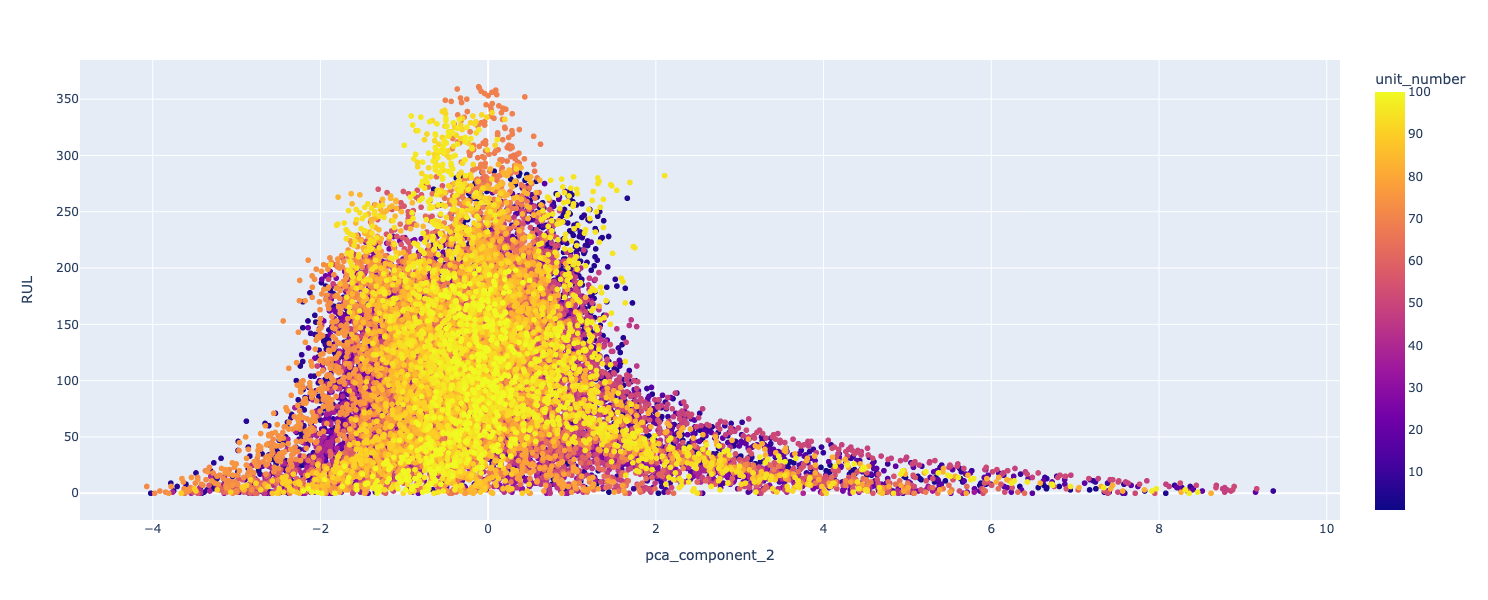

In [38]:
# now let's plot the 2 PCA components for all units and the RUL and see if we can detect any interesting pattern
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2))
])
pca_components = pipeline.fit_transform(df[features])
for i in range(pca_components.shape[1]):
    df[f"pca_component_{i+1}"] = pca_components[:, i]

# also add the pca components to the test data
pca_components = pipeline.fit_transform(df_test[features])
for i in range(pca_components.shape[1]):
    df_test[f"pca_component_{i+1}"] = pca_components[:, i]

for c in ["pca_component_1", "pca_component_2"]:
    fig = px.scatter(df, x=c, y="RUL", color="unit_number", width=800, height=600)
    fig.show()

## Modeling

### Transformations

In [39]:
# re-arrange pca columns before max_cyles and RUL
column_to_move_1 = df.pop("pca_component_1")
column_to_move_2 = df.pop("pca_component_2")

df.insert(19, 'pca_component_1', column_to_move_1)
df.insert(20, 'pca_component_2', column_to_move_2)

In [40]:
df.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1    -0.0007    -0.0004         641.82   
1            1               2     0.0019    -0.0003         642.15   
2            1               3    -0.0043     0.0003         642.35   
3            1               4     0.0007     0.0000         642.35   
4            1               5    -0.0019    -0.0002         642.37   

   measurement_3  measurement_4  measurement_6  measurement_7  measurement_8  \
0        1589.70        1400.60          21.61         554.36        2388.06   
1        1591.82        1403.14          21.61         553.75        2388.04   
2        1587.99        1404.20          21.61         554.26        2388.08   
3        1582.79        1401.87          21.61         554.45        2388.11   
4        1582.85        1406.22          21.61         554.00        2388.06   

   ...  measurement_13  measurement_14  measurement_15  measurement_17  \
0  ...         2388.02         8138.62          8.4195             392   
1  ...         2388.07         8131.49          8.4318             392   
2  ...         2388.03         8133.23          8.4178             390   
3  ...         2388.08         8133.83          8.3682             392   
4  ...         2388.04         8133.80          8.4294             393   

   measurement_20  measurement_21  pca_component_1  pca_component_2  \
0           39.06         23.4190        -2.952779        -0.432160   
1           39.00         23.4236        -2.363669        -0.786891   
2           38.95         23.3442        -2.978665        -0.552425   
3           38.88         23.3739        -3.384151        -0.843775   
4           38.90         23.4044        -2.428327        -0.363281   

   max_cycles  RUL  
0         192  191  
1         192  190  
2         192  189  
3         192  188  
4         192  187  

[5 rows x 23 columns]

In [41]:
column_to_move_1 = df_test.pop("pca_component_1")
column_to_move_2 = df_test.pop("pca_component_2")

df_test.insert(19, 'pca_component_1', column_to_move_1)
df_test.insert(20, 'pca_component_2', column_to_move_2)

In [42]:
df_test.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1     0.0023     0.0003         643.02   
1            1               2    -0.0027    -0.0003         641.71   
2            1               3     0.0003     0.0001         642.46   
3            1               4     0.0042     0.0000         642.44   
4            1               5     0.0014     0.0000         642.51   

   measurement_3  measurement_4  measurement_6  measurement_7  measurement_8  \
0        1585.29        1398.21          21.61         553.90        2388.04   
1        1588.45        1395.42          21.61         554.85        2388.01   
2        1586.94        1401.34          21.61         554.11        2388.05   
3        1584.12        1406.42          21.61         554.07        2388.03   
4        1587.19        1401.92          21.61         554.16        2388.01   

   ...  measurement_12  measurement_13  measurement_14  measurement_15  \
0  ...          521.72         2388.03         8125.55          8.4052   
1  ...          522.16         2388.06         8139.62          8.3803   
2  ...          521.97         2388.03         8130.10          8.4441   
3  ...          521.38         2388.05         8132.90          8.3917   
4  ...          522.15         2388.03         8129.54          8.4031   

   measurement_17  measurement_20  measurement_21  pca_component_1  \
0             392           38.86         23.3735        -1.094471   
1             393           39.02         23.3916        -2.623131   
2             393           39.08         23.4166        -0.965097   
3             391           39.00         23.3737        -1.487497   
4             390           38.99         23.4130        -2.316995   

   pca_component_2  max_cycles  
0        -1.349793          31  
1        -0.440283          31  
2        -0.614833          31  
3        -1.446918          31  
4        -1.645888          31  

[5 rows x 22 columns]

#### Scaling

In [43]:
# scale all setting and measurements columns both in train and test
scaler = MinMaxScaler()
df.iloc[:,2:21] = scaler.fit_transform(df.iloc[:,2:21])
df_test.iloc[:,2:21] = scaler.transform(df_test.iloc[:,2:21])

/var/folders/wy/fn4vzkqd1c7gtprtw67bjwdh0000gn/T/ipykernel_2031/3114219733.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.33333333 0.16666667 ... 0.83333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/wy/fn4vzkqd1c7gtprtw67bjwdh0000gn/T/ipykernel_2031/3114219733.py:4: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.41666667 0.41666667 ... 0.58333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [44]:
df.describe()

unit_number  time_in_cycles     setting_1     setting_2  \
count  20631.000000    20631.000000  20631.000000  20631.000000   
mean      51.506568      108.807862      0.499490      0.501959   
std       29.227633       68.880990      0.125708      0.244218   
min        1.000000        1.000000      0.000000      0.000000   
25%       26.000000       52.000000      0.413793      0.333333   
50%       52.000000      104.000000      0.500000      0.500000   
75%       77.000000      156.000000      0.586207      0.750000   
max      100.000000      362.000000      1.000000      1.000000   

       measurement_2  measurement_3  measurement_4  measurement_6  \
count   20631.000000   20631.000000   20631.000000   20631.000000   
mean        0.443052       0.424746       0.450435       0.980321   
std         0.150618       0.133664       0.151935       0.138898   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.335843       0.331807       0.339467       1.000000   
50%         0.430723       0.415522       0.435348       1.000000   
75%         0.539157       0.508829       0.545324       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

       measurement_7  measurement_8  ...  measurement_13  measurement_14  \
count   20631.000000   20631.000000  ...    20631.000000    20631.000000   
mean        0.566459       0.297957  ...        0.317871        0.226095   
std         0.142527       0.107554  ...        0.105763        0.098442   
min         0.000000       0.000000  ...        0.000000        0.000000   
25%         0.476651       0.227273  ...        0.235294        0.171870   
50%         0.578100       0.287879  ...        0.308824        0.209516   
75%         0.669887       0.363636  ...        0.382353        0.249613   
max         1.000000       1.000000  ...        1.000000        1.000000   

       measurement_15  measurement_17  measurement_20  measurement_21  \
count    20631.000000    20631.000000    20631.000000    20631.000000   
mean         0.451118        0.434221        0.524241        0.546127   
std          0.144306        0.129064        0.140114        0.149476   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.346287        0.333333        0.434109        0.452361   
50%          0.438630        0.416667        0.534884        0.557443   
75%          0.541362        0.500000        0.627907        0.652582   
max          1.000000        1.000000        1.000000        1.000000   

       pca_component_1  pca_component_2    max_cycles           RUL  
count     20631.000000     20631.000000  20631.000000  20631.000000  
mean          0.377702         0.303053    216.615724    107.807862  
std           0.168603         0.107846     50.028600     68.880990  
min           0.000000         0.000000    128.000000      0.000000  
25%           0.250855         0.239037    185.000000     51.000000  
50%           0.358581         0.293926    207.000000    103.000000  
75%           0.472197         0.343847    240.000000    155.000000  
max           1.000000         1.000000    362.000000    361.000000  

[8 rows x 23 columns]

In [45]:
df_test.describe()

unit_number  time_in_cycles     setting_1     setting_2  \
count  13096.000000    13096.000000  13096.000000  13096.000000   
mean      51.543907       76.836515      0.499358      0.503532   
std       28.289423       53.057749      0.126591      0.245025   
min        1.000000        1.000000      0.028736      0.000000   
25%       28.000000       33.000000      0.413793      0.333333   
50%       52.000000       69.000000      0.500000      0.500000   
75%       76.000000      113.000000      0.586207      0.750000   
max      100.000000      303.000000      0.948276      1.083333   

       measurement_2  measurement_3  measurement_4  measurement_6  \
count   13096.000000   13096.000000   13096.000000   13096.000000   
mean        0.381051       0.371903       0.379564       0.970067   
std         0.120753       0.109075       0.112902       0.170408   
min        -0.024096      -0.043601       0.036124       0.000000   
25%         0.297440       0.295618       0.298785       1.000000   
50%         0.376506       0.369523       0.374578       1.000000   
75%         0.460843       0.443046       0.452397       1.000000   
max         0.930723       0.795945       0.862762       1.000000   

       measurement_7  measurement_8  ...  measurement_12  measurement_13  \
count   13096.000000   13096.000000  ...    13096.000000    13096.000000   
mean        0.629231       0.259037  ...        0.651967        0.280919   
std         0.109708       0.087033  ...        0.119323        0.083727   
min         0.165862      -0.015152  ...        0.147122        0.014706   
25%         0.557166       0.196970  ...        0.573561        0.220588   
50%         0.636071       0.257576  ...        0.658849        0.279412   
75%         0.706924       0.318182  ...        0.737740        0.338235   
max         0.964573       0.606061  ...        1.081023        0.647059   

       measurement_14  measurement_15  measurement_17  measurement_20  \
count    13096.000000    13096.000000    13096.000000    13096.000000   
mean         0.201299        0.388395        0.380969        0.583335   
std          0.052578        0.111617        0.102798        0.109830   
min          0.044174        0.030396        0.083333        0.131783   
25%          0.167045        0.310504        0.333333        0.511628   
50%          0.198421        0.384763        0.416667        0.589147   
75%          0.229229        0.459407        0.416667        0.658915   
max          0.622046        0.833013        0.750000        0.984496   

       measurement_21  pca_component_1  pca_component_2    max_cycles  
count    13096.000000     13096.000000     13096.000000  13096.000000  
mean         0.609697         0.377702         0.303053    152.673030  
std          0.116156         0.151129         0.105758     51.165573  
min          0.056890         0.032125         0.011411     31.000000  
25%          0.534935         0.259750         0.233999    125.000000  
50%          0.614471         0.366508         0.291508    152.000000  
75%          0.689589         0.478201         0.353542    186.000000  
max          1.032450         1.011620         1.209958    303.000000  

[8 rows x 22 columns]

In [46]:
# scale the RUL in a similar fashion so the values are between 0 and 1
df_train = (df.groupby("unit_number", group_keys=False).apply(lambda x: x.assign(fRUL=(x["RUL"] - x["RUL"].min()) / (x["RUL"].max() - x["RUL"].min()))))

/var/folders/wy/fn4vzkqd1c7gtprtw67bjwdh0000gn/T/ipykernel_2031/225252238.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [47]:
# display the columns available in training data
pd.DataFrame(df_train.columns).T

0               1          2          3              4   \
0  unit_number  time_in_cycles  setting_1  setting_2  measurement_2   

              5              6              7              8              9   \
0  measurement_3  measurement_4  measurement_6  measurement_7  measurement_8   

   ...              14              15              16              17  \
0  ...  measurement_14  measurement_15  measurement_17  measurement_20   

               18               19               20          21   22    23  
0  measurement_21  pca_component_1  pca_component_2  max_cycles  RUL  fRUL  

[1 rows x 24 columns]

In [48]:
# display the columns available in test data
pd.DataFrame(df_test.columns).T

0               1          2          3              4   \
0  unit_number  time_in_cycles  setting_1  setting_2  measurement_2   

              5              6              7              8              9   \
0  measurement_3  measurement_4  measurement_6  measurement_7  measurement_8   

   ...              12              13              14              15  \
0  ...  measurement_12  measurement_13  measurement_14  measurement_15   

               16              17              18               19  \
0  measurement_17  measurement_20  measurement_21  pca_component_1   

                20          21  
0  pca_component_2  max_cycles  

[1 rows x 22 columns]

### Train a regressor

In [49]:
# compose X_train, y_train, X_val
X_train = df_train.values[:,1:21]
y_train = df_train.values[:,23]
X_test = df_test.values[:,1:21]

# instantiate regressor
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

# generate scores/predictions
score = regressor.predict(X_test)

### Evaluate the model

In [50]:
# add the score to the test data
df_test['predicted_fRUL'] = score

In [51]:
df_test.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1   0.632184   0.750000       0.545181   
1            1               2   0.344828   0.250000       0.150602   
2            1               3   0.517241   0.583333       0.376506   
3            1               4   0.741379   0.500000       0.370482   
4            1               5   0.580460   0.500000       0.391566   

   measurement_3  measurement_4  measurement_6  measurement_7  measurement_8  \
0       0.310661       0.269413            1.0       0.652174       0.212121   
1       0.379551       0.222316            1.0       0.805153       0.166667   
2       0.346632       0.322248            1.0       0.685990       0.227273   
3       0.285154       0.408001            1.0       0.679549       0.196970   
4       0.352082       0.332039            1.0       0.694042       0.166667   

   ...  measurement_13  measurement_14  measurement_15  measurement_17  \
0  ...        0.220588        0.132160        0.308965        0.333333   
1  ...        0.264706        0.204768        0.213159        0.416667   
2  ...        0.220588        0.155640        0.458638        0.416667   
3  ...        0.250000        0.170090        0.257022        0.250000   
4  ...        0.220588        0.152751        0.300885        0.166667   

   measurement_20  measurement_21  pca_component_1  pca_component_2  \
0        0.558140        0.661834         0.316284         0.202574   
1        0.682171        0.686827         0.230501         0.270278   
2        0.728682        0.721348         0.323544         0.257285   
3        0.666667        0.662110         0.294229         0.195344   
4        0.658915        0.716377         0.247680         0.180533   

   max_cycles  predicted_fRUL  
0          31        1.000000  
1          31        0.995237  
2          31        0.989420  
3          31        0.985131  
4          31        0.980314  

[5 rows x 23 columns]

In [52]:
# now we need to convert the fraction RUL to the number of cycles
df_test = (df_test.groupby("unit_number", group_keys=False).apply(lambda x: x.assign(predicted_RUL=
                                                                                                   (x["time_in_cycles"] / (1 - x["predicted_fRUL"])) - x["max_cycles"])))

/var/folders/wy/fn4vzkqd1c7gtprtw67bjwdh0000gn/T/ipykernel_2031/1088151362.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [53]:
df_test.head()

unit_number  time_in_cycles  setting_1  setting_2  measurement_2  \
0            1               1   0.632184   0.750000       0.545181   
1            1               2   0.344828   0.250000       0.150602   
2            1               3   0.517241   0.583333       0.376506   
3            1               4   0.741379   0.500000       0.370482   
4            1               5   0.580460   0.500000       0.391566   

   measurement_3  measurement_4  measurement_6  measurement_7  measurement_8  \
0       0.310661       0.269413            1.0       0.652174       0.212121   
1       0.379551       0.222316            1.0       0.805153       0.166667   
2       0.346632       0.322248            1.0       0.685990       0.227273   
3       0.285154       0.408001            1.0       0.679549       0.196970   
4       0.352082       0.332039            1.0       0.694042       0.166667   

   ...  measurement_14  measurement_15  measurement_17  measurement_20  \
0  ...        0.132160        0.308965        0.333333        0.558140   
1  ...        0.204768        0.213159        0.416667        0.682171   
2  ...        0.155640        0.458638        0.416667        0.728682   
3  ...        0.170090        0.257022        0.250000        0.666667   
4  ...        0.152751        0.300885        0.166667        0.658915   

   measurement_21  pca_component_1  pca_component_2  max_cycles  \
0        0.661834         0.316284         0.202574          31   
1        0.686827         0.230501         0.270278          31   
2        0.721348         0.323544         0.257285          31   
3        0.662110         0.294229         0.195344          31   
4        0.716377         0.247680         0.180533          31   

   predicted_fRUL  predicted_RUL  
0        1.000000            inf  
1        0.995237     388.881632  
2        0.989420     252.560872  
3        0.985131     238.012294  
4        0.980314     222.984145  

[5 rows x 24 columns]

In [54]:
# get the list of predicted RULs
t = df_test.columns == 'predicted_RUL'
ind = [i for i, x in enumerate(t) if x]
predictedRUL = []
for i in range(df_test.unit_number.min(), df_test.unit_number.max()+1):
 npredictedRUL=df_test[df_test.unit_number==i].iloc[df_test[df_test.unit_number==i].time_in_cycles.max()-1,ind]
 predictedRUL.append(npredictedRUL)
    
xpredictedRUL = list(round(x) for x in predictedRUL)
xpredictedRUL1= []
for i in range(0,len(xpredictedRUL)):
    xpredictedRUL1.append(int(xpredictedRUL[i]))  
xpredictedRUL2 = np.array(xpredictedRUL1)

/var/folders/wy/fn4vzkqd1c7gtprtw67bjwdh0000gn/T/ipykernel_2031/2582173651.py:12: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



In [55]:
xpredictedRUL2

array([157, 146,  26,  36,  52,  74,  67,  38, 124,  66,  47,  73,  55,
       123, 150,  88,  42,  21,  95,   2,  55, 167, 102,  19, 140,  95,
        74,  64,  76,  51,   2,  38, 122,   1,   2,   2,  17,  26, 155,
         4,  16,   1,  33, 135,  39,  29,  75, 118,   4, 112,  62,  18,
        28, 124, 100,   1,  45,  11, 133,  68,  11,  60,  27,  14, 152,
         6, 130,   2, 148,  56, 125,  51, 113,  53, 116,   2,   9, 139,
        54,  42,   1,   1, 127,  16, 140,  62, 146, 108,  55,  13,   5,
         2,  31,  18, 113, 123,  61,  56, 118,  11])

In [56]:
# get both the true and predicted RULs and their difference
df1 = pd.concat([pd.Series(df_rul['remaining_cycles']), pd.Series(xpredictedRUL2)], axis=1)
df1.columns = ['true', 'predicted']
df1['diff'] = df1['predicted']-df1['true']
df1.head()

true  predicted  diff
0   112        157    45
1    98        146    48
2    69         26   -43
3    82         36   -46
4    91         52   -39

In [57]:
pd.DataFrame({'Count': [(df1['diff']<0).sum(), (df1['diff']==0).sum(),
 (df1['diff']>0).sum()]}, columns=['Count'], index=['Smaller', 'Zero', 'Larger'])

Count
Smaller     72
Zero         0
Larger      28

In [58]:
# compute the R Square for model from sklearn import metrics
print("Random Forest R-squared", "{:.2%}".format(metrics.r2_score(xpredictedRUL, df_rul['remaining_cycles'].values)))

Random Forest R-squared 61.02%


In [59]:
feature_labels = np.array(['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_6',
 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 
                           'measurement_17', 'measurement_20', 'measurement_21', 'pca_component_1', 'pca_component_2', 'max_cycles'])
importance = regressor.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
for index in feature_indexes_by_importance:
 print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

unit_number-81.95%
measurement_21-13.60%
measurement_8-0.79%
measurement_13-0.54%
pca_component_1-0.30%
measurement_11-0.26%
measurement_6-0.25%
measurement_9-0.24%
measurement_3-0.24%
measurement_20-0.24%
measurement_2-0.23%
measurement_14-0.23%
setting_2-0.22%
time_in_cycles-0.22%
measurement_17-0.19%
measurement_7-0.15%
measurement_12-0.14%
setting_1-0.14%
measurement_15-0.07%
measurement_4-0.00%
